Evaluating generative text models

In [1]:
from importlib.metadata import version
pkgs = ["matplotlib",
       "numpy",
       "tiktoken",
       "torch",
       "tensorflow"]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.6.0
tensorflow version: 2.19.0


In [2]:
from previous_chapters import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary Size
    "context_length":128, # Context Length
    "emb_dim":768, # Embedding dimension
    "n_heads":12, # Number of attention heads in each transformer block
    "n_layers":12, # Number of layers of transformer blocks
    "drop_rate":0.1, # Drop rate
    "qkv_bias":False # Query-Key-Value bias
}

In [3]:
import torch
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # added batch dimension
    return encoded_tensor
    

In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = text_to_token_ids(start_context,tokenizer)
token_ids

tensor([[6109, 3626, 6100,  345]])

In [6]:
def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

token_ids_to_text(token_ids,tokenizer)

'Every effort moves you'

In [7]:
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size = GPT_CONFIG_124M['context_length']
)

In [8]:
token_ids_to_text(token_ids,tokenizer)

'Every effort moves you Spirits caves Feng lith cohorts Physical Position Wind Bars Vern'

Calculating the text generation loss: cross-entropy and perplexitiy

In [9]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [10]:
with torch.no_grad():
    logits = model(inputs)

In [11]:
logits.shape

torch.Size([2, 3, 50257])

In [12]:
probas = torch.softmax(logits,dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [13]:
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print('Token IDs:\n',token_ids)

Token IDs:
 tensor([[[38862],
         [43027],
         [ 8569]],

        [[42085],
         [31970],
         [16774]]])


In [14]:
print(f"Targets batch 1: {token_ids_to_text(targets[0],tokenizer)}")
print(f"Predictions batch 1: {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1:  effort moves you
Predictions batch 1:  doverank comprehens


In [15]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2],targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([3.3706e-05, 2.9752e-05, 1.4406e-05])


In [16]:
text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2],targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([2.1550e-05, 1.7313e-05, 1.7490e-05])


In [17]:
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([-10.2978, -10.4226, -11.1479, -10.7451, -10.9641, -10.9539])


In [18]:
-1 * torch.mean(log_probas)

tensor(10.7552)

In [19]:
logits_flat = logits.flatten(0,1)
logits_flat.shape

torch.Size([6, 50257])

In [20]:
targets_flat = targets.flatten()
targets_flat.shape

torch.Size([6])

In [21]:
torch.nn.functional.cross_entropy(logits_flat,targets_flat)

tensor(10.7552)

Calculating the training and validation set losses

In [22]:
import os
with open('the-verdict.txt','r',encoding='utf-8') as file:
    text_data = file.read()

In [23]:
text_data[:13]

'I HAD always '

In [24]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print('Characters:', total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [25]:
int(0.9*len(text_data))

18431

In [26]:
text_data[:18431]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [27]:
from previous_chapters import create_dataloader_v1
train_ratio =0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [28]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [29]:
print("Train loader:")
for x,y in train_loader:
    pass
print(x.shape,y.shape)

Train loader:
torch.Size([2, 128]) torch.Size([2, 128])


In [30]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:",train_tokens)
print("Validation tokens:",val_tokens)
print("All tokens:",train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [31]:
torch.cuda.is_available()

True

In [32]:
len(train_loader)

18

In [33]:
len(val_loader)

2

In [34]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch = input_batch.to(device),target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [35]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)

print("Training Loss:",train_loss)
print("Validation Loss",val_loss)

Training Loss: 11.01280132929484
Validation Loss 10.996222972869873


In [36]:
# perplexity
# how unsure the llm for each word
torch.exp((torch.tensor(10.987583690)))

tensor(59135.3477)

In [37]:
tokenizer.n_vocab

50257

Training an LLM

In [38]:
def train_model_simple(model,train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step +=1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                     f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(model,tokenizer,device,start_context)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader ,val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model,device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model,device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model = model, idx = encoded, max_new_tokens = 50, context_size = context_size)
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [39]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)

In [40]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer=optimizer,
                                                          device = device,num_epochs = num_epochs,
                                                          eval_freq=5, eval_iter=5, start_context ="Every effort moves you",
                                                          tokenizer = tokenizer)

Ep 1 (Step 000000): Train loss 9.910, Val loss 10.194
Ep 1 (Step 000005): Train loss 8.299, Val loss 8.527
Ep 1 (Step 000010): Train loss 7.299, Val loss 7.421
Ep 1 (Step 000015): Train loss 6.462, Val loss 6.819
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000020): Train loss 6.203, Val loss 6.635
Ep 2 (Step 000025): Train loss 5.677, Val loss 6.501
Ep 2 (Step 000030): Train loss 5.850, Val loss 6.508
Ep 2 (Step 000035): Train loss 5.505, Val loss 6.521
Every effort moves you, and the a a a, and a, and a the the a, and a a a a, and I had the a, and the a, and a, and the a a, and the a a a a, and the a
Ep 3 (Step 000040): Train loss 5.283, Val loss 6.474
Ep 3 (Step 000045): Train loss 5.268, Val loss 6.363
Ep 3 (Step 000050): Train loss 4.725, Val loss 6.253
Every effort moves you, I was a little the picture. "--I had been to the. I had been's.  "I had been, I was his the him, I had been. I had been his a little, I had been his
Ep 4 (Step 000055):

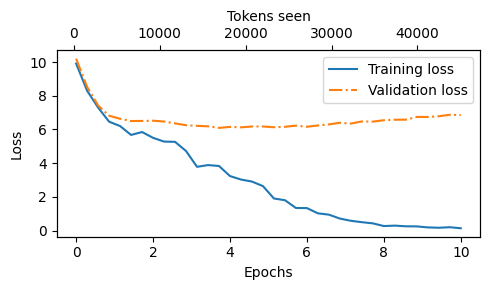

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Decoding Strategies to control randomness

In [42]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output text:\n", token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"
""Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Temperature scaling

In [43]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v:k for k,v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [44]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits,dim=0)
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [45]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [46]:
inverse_vocab[next_token_id]

'forward'

In [47]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas,num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [48]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas,num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [49]:
def softmax_with_temperature(logits,temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits,dim=0)

In [50]:
temperatures = [1,0.1,5]
scaled_probas = [softmax_with_temperature(next_token_logits,T) for T in temperatures] 

In [51]:
scaled_probas[0]

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [52]:
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [53]:
scaled_probas[1]

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])

In [54]:
scaled_probas[2]

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])

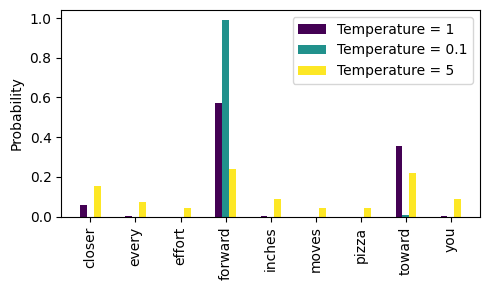

In [55]:
import numpy as np
x = torch.arange(len(vocab))
bar_width = 0.15

# Create a color palette - using a colormap for visually distinct colors
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(temperatures)))

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, 
                  label=f'Temperature = {T}', 
                  color=colors[i])  # Assign a unique color to each temperature

ax.set_ylabel('Probability')
ax.set_xticks(x + bar_width * (len(temperatures) - 1) / 2)  # Center x-ticks
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
#plt.savefig("temperature-plot.pdf")
plt.show()

Top-k sampling

In [56]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [57]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits,top_k)
print(top_logits,top_pos)

tensor([6.7500, 6.2800, 4.5100]) tensor([3, 7, 0])


In [58]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other = next_token_logits
)
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [59]:
torch.softmax(new_logits,dim=0)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

Modifying the text generation function

In [60]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]

        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
            
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples = 1)

        else:
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)

        if idx_next == eos_id:
            break
        idx = torch.cat((idx,idx_next),dim=1)

    return idx
        
    

In [61]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"
""Yes--quite insensible to the irony. She wanted


Loading and saving model weights in PyTorch

In [62]:
#torch.save(model.state_dict(),"model.pth")

Loading pretrained weights from OpenAI

In [63]:
print("Tensor Flow version:",version("tensorflow"))
print("tqdm version:",version("tqdm"))

Tensor Flow version: 2.19.0
tqdm version: 4.67.1


In [64]:
from gpt_download import download_and_load_gpt2

2025-04-11 18:49:46.304509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 18:49:46.424701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744386586.471338    3269 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744386586.484016    3269 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744386586.591293    3269 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [67]:
settings, params = download_and_load_gpt2(model_size="124M",models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json


model.ckpt.data-00000-of-00001: 100%|████████████████████████████████████████████████| 498M/498M [23:37<00:00, 351kiB/s]
model.ckpt.index: 100%|███████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 6.80MiB/s]
model.ckpt.meta: 100%|███████████████████████████████████████████████████████████████| 471k/471k [00:01<00:00, 389kiB/s]
vocab.bpe: 100%|█████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 306kiB/s]


In [78]:
settings

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

In [77]:
params.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

In [68]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [69]:
def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [70]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [75]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I
